In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

In [27]:
import pymc as pm

In [28]:
# Importing dataset
columns = ['lenght_of_stay', 'age', 'infection_risk', 'routine_culturing_ratio', 'routine_xray_ratio', 'num_beds', 'med_school_affil', 'region', 'avg_census', 'num_nurses', 'avelbl_services']
df = pd.read_csv("data/dataset.txt", sep=" ", header=None, names=columns)
df.head()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,med_school_affil,region,avg_census,num_nurses,avelbl_services
1,7.13,55.7,4.1,9.0,39.6,279,2,4,207,241,60.0
2,8.82,58.2,1.6,3.8,51.7,80,2,2,51,52,40.0
3,8.34,56.9,2.7,8.1,74.0,107,2,3,82,54,20.0
4,8.95,53.7,5.6,18.9,122.8,147,2,4,53,148,40.0
5,11.20,56.5,5.7,34.5,88.9,180,2,1,134,151,40.0


In [29]:
df = pd.get_dummies(df, columns=['med_school_affil', 'region'])
df.head()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,num_beds,avg_census,num_nurses,avelbl_services,med_school_affil_1,med_school_affil_2,region_1,region_2,region_3,region_4
1,7.13,55.7,4.1,9.0,39.6,279,207,241,60.0,False,True,False,False,False,True
2,8.82,58.2,1.6,3.8,51.7,80,51,52,40.0,False,True,False,True,False,False
3,8.34,56.9,2.7,8.1,74.0,107,82,54,20.0,False,True,False,False,True,False
4,8.95,53.7,5.6,18.9,122.8,147,53,148,40.0,False,True,False,False,False,True
5,11.20,56.5,5.7,34.5,88.9,180,134,151,40.0,False,True,True,False,False,False


In [30]:
df['ln_num_nurses'] = np.log(df['num_nurses'])
df['ln_num_beds'] = np.log(df['num_beds'])
df['ln_avg_census'] = np.log(df['avg_census'])
df.drop(columns=['num_nurses', 'num_beds', 'avg_census'], inplace=True)

In [31]:
df.astype(float).head()

,lenght_of_stay,age,infection_risk,routine_culturing_ratio,routine_xray_ratio,avelbl_services,med_school_affil_1,med_school_affil_2,region_1,region_2,region_3,region_4,ln_num_nurses,ln_num_beds,ln_avg_census
1,7.13,55.7,4.1,9.0,39.6,60.0,0.0,1.0,0.0,0.0,0.0,1.0,5.484797,5.631212,5.332719
2,8.82,58.2,1.6,3.8,51.7,40.0,0.0,1.0,0.0,1.0,0.0,0.0,3.951244,4.382027,3.931826
3,8.34,56.9,2.7,8.1,74.0,20.0,0.0,1.0,0.0,0.0,1.0,0.0,3.988984,4.672829,4.406719
4,8.95,53.7,5.6,18.9,122.8,40.0,0.0,1.0,0.0,0.0,0.0,1.0,4.997212,4.990433,3.970292
5,11.20,56.5,5.7,34.5,88.9,40.0,0.0,1.0,1.0,0.0,0.0,0.0,5.017280,5.192957,4.897840


In [32]:
corr_matrix = df.corr()
corr_matrix['infection_risk'].sort_values(ascending=False)

infection_risk             1.000000
routine_culturing_ratio    0.559159
ln_num_nurses              0.545871
lenght_of_stay             0.533444
ln_avg_census              0.461560
routine_xray_ratio         0.453392
ln_num_beds                0.448110
avelbl_services            0.412601
med_school_affil_1         0.233030
region_1                   0.217480
region_2                   0.018307
region_4                   0.008026
age                        0.001093
region_3                  -0.223618
med_school_affil_2        -0.233030
Name: infection_risk, dtype: float64

In [33]:
# Separating covariates and target
if 'infection_risk' in df.columns:
    Y = df.pop("infection_risk").astype(float)

In [34]:
df -= df.mean()
df /= df.std()

In [35]:
df_complete = df.astype(float)
df_top8 = df.drop(columns=['age', 'region_1', 'region_2', 'region_3', 'region_4',]).astype(float)
df_top5 = df_top8.drop(columns=['med_school_affil_1', 'med_school_affil_2', 'avelbl_services', 'ln_num_beds']).astype(float)
df_top4 = df_top5.drop(columns='routine_xray_ratio').astype(float)
df_top3 = df_top4.drop(columns='ln_avg_census').astype(float)
df_top2 = df_top3.drop(columns='lenght_of_stay').astype(float)
df_top1 = df_top2.drop(columns='ln_num_nurses').astype(float)
dfs = [df_complete, df_top8, df_top5, df_top4, df_top3, df_top2]

In [36]:
model_complete = pm.Model()
model_top8 = pm.Model()
model_top5 = pm.Model()
model_top4 = pm.Model()
model_top3 = pm.Model()
model_top2 = pm.Model()
# model_top1 = pm.Model()
models = [model_complete, model_top8, model_top5, model_top4, model_top3, model_top2]

In [37]:
for df, model in zip(dfs, models):
    with model:
        # Priors for unknown model parameters
        alpha = pm.Normal("alpha", mu=0, sigma=10)
        beta = pm.Normal("beta", mu=0, sigma=10, shape=df.shape[1])
        sigma = pm.HalfNormal("sigma", sigma=1)

        # Expected value of outcome
        mu = alpha + pm.math.dot(df, beta)

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [38]:
idata = []
for i, model in enumerate(models):
    with model:
        step = pm.Metropolis()
        idata.append(pm.sample(10000, step=step, idata_kwargs = {'log_likelihood': True}))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 63 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 83 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 70 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 99 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 48 seconds.


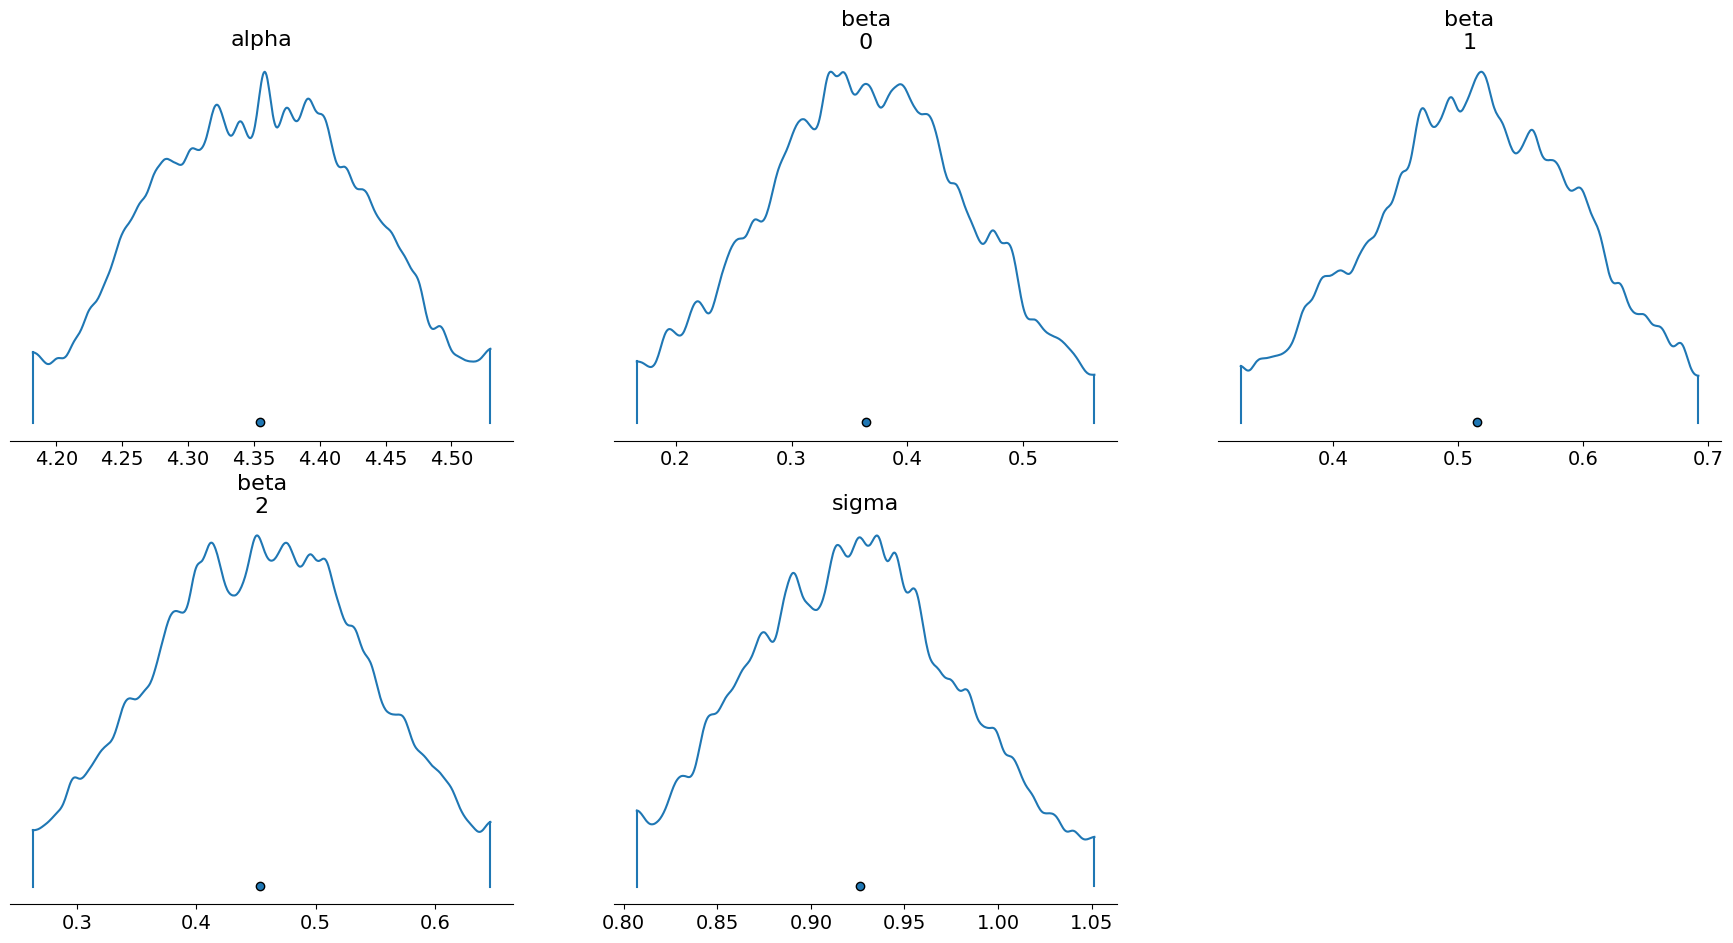

In [39]:
# Plot posterior densities of parameters
az.plot_density(idata[4], group='posterior', hdi_prob=0.95);

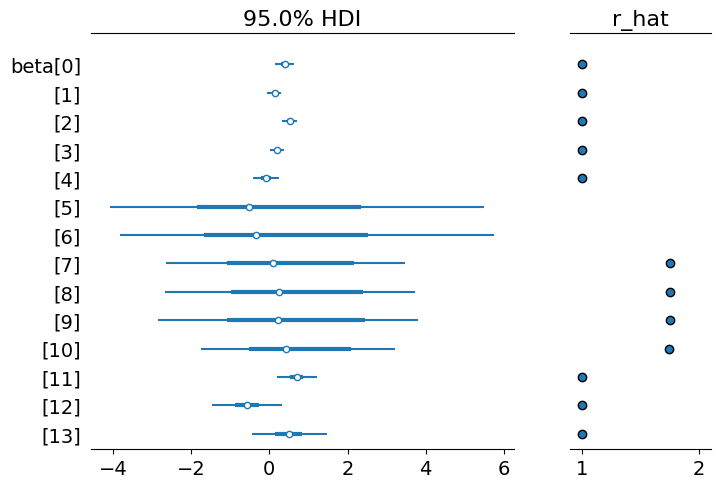

In [40]:
# Plot parameters for covariates
az.plot_forest(idata[0], var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

In [41]:
model_trace_dict = dict()

for i, num in enumerate(['top10', 'top8', 'top5', 'top4', 'top3', 'top2']):
    models[i].name = num
    model_trace_dict.update({num: idata[i]})

In [42]:
dfwaic = az.compare(model_trace_dict, ic='WAIC')

c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\davig\anaconda3\envs\comp_stats\Lib\site-packages\arviz\stats\stats

In [44]:
dfwaic

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
top10,0,-151.362661,13.432601,0.000000,0.562020,7.371304,0.000000,True,log
top5,1,-151.833964,6.851923,0.471303,0.246237,7.401039,3.909221,True,log
top4,2,-153.237510,6.411606,1.874848,0.000000,7.666159,4.458014,True,log
top8,3,-153.430843,9.641849,2.068182,0.000000,7.312046,3.553647,True,log
top3,4,-154.183968,5.572460,2.821306,0.191744,7.594521,4.931387,True,log
top2,5,-159.927250,4.797662,8.564589,0.000000,7.682697,5.780464,True,log


In [45]:
# Plot summary of parameters
# az.summary(idata, round_to=2)

In [46]:
# Y_pred = pm.sample_posterior_predictive(idata, model=basic_model) # for each sample it draws a beta from each found beta distribution -> finds Y_pred for all X

In [48]:
# import matplotlib.pyplot as plt
# # fig, ax = plt.subplots()
# # plt.xlim(0,10)
# # az.plot_ppc(Y_pred, num_pp_samples=100, ax=ax)
# az.plot_ppc(Y_pred, num_pp_samples=100)